In [3]:
from fastapi import FastAPI, HTTPException
from sqlalchemy import create_engine, Column, Integer, String, DateTime, func
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
import pandas as pd
import fastavro
import os
from datetime import datetime
import mysql.connector
import uvicorn
import asyncio
import nest_asyncio

# CHALLENGE 1

In [173]:
conexion= mysql.connector.connect(user='root',password='Jh11092159.',
                                  host='localhost',database='prueba',port='3306')
print(conexion)

In [87]:
df_emp = pd.read_csv("hired_employees.csv",sep=',',header=None, names=['id', 'name','datetime','department_id','job_id'])
df_emp['datetime'] = pd.to_datetime(df_emp['datetime'])
df_emp['name'] = df_emp['name'].fillna('')  # Rellenar con cadena vacía
df_emp['department_id'] = df_emp['department_id'].fillna(0)  # Rellenar con 0
df_emp['job_id'] = df_emp['job_id'].fillna(0)  # Rellenar con 0
df_emp.head()

,id,name,datetime,department_id,job_id
0,1,Harold Vogt,2021-11-07 02:48:42+00:00,2.0,96.0
1,2,Ty Hofer,2021-05-30 05:43:46+00:00,8.0,0.0
2,3,Lyman Hadye,2021-09-01 23:27:38+00:00,5.0,52.0
3,4,Lotti Crowthe,2021-10-01 13:04:21+00:00,12.0,71.0
4,5,Gretna Lording,2021-10-10 22:22:17+00:00,6.0,80.0


### CREAR TABLAS EN MYSQL

In [117]:

# Función para crear las tablas
def create_tables():
    try:
        cursor = conexion.cursor()

        # Crear tabla departments
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS departments (
                id INT PRIMARY KEY,
                department VARCHAR(255) NOT NULL
            )
        """)

        # Crear tabla jobs
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS jobs (
                id INT PRIMARY KEY,
                job VARCHAR(255) NOT NULL
            )
        """)

        # Crear tabla hired_employees
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS hired_employees (
                id INT PRIMARY KEY,
                name VARCHAR(255),
                datetime DATETIME,
                department_id INT,
                job_id INT
            )
        """)

        conexion.commit()
        cursor.close()
        print("Tablas creadas exitosamente.")
    except Exception as e:
        print(f"Error al crear las tablas: {e}")
        raise Exception(f"Error al crear las tablas: {e}")

# Ejecutar la función create_tables
create_tables()

Tablas creadas exitosamente.


### HACER INGESTA DE DATOS DESDE ARCHIVOS CSV

In [193]:
# Cargar datos desde CSV
def load_csv_to_db():
    try:
        cursor = conexion.cursor()

        # Cargar departamentos
        df_dept = pd.read_csv("departments.csv",sep=',',header=None, names=['id', 'department'])
        for _, row in df_dept.iterrows():
            cursor.execute("INSERT INTO departments (id, department) VALUES (%s, %s)", (row['id'], row['department']))

        # Cargar trabajos
        df_jobs = pd.read_csv("jobs.csv",sep=',',header=None, names=['id', 'job'])
        for _, row in df_jobs.iterrows():
            cursor.execute("INSERT INTO jobs (id, job) VALUES (%s, %s)", (row['id'], row['job']))

        # Cargar empleados
        df_emp = pd.read_csv("hired_employees.csv",sep=',',header=None, names=['id', 'name','datetime','department_id','job_id'])
        df_emp['datetime'] = pd.to_datetime(df_emp['datetime'])
        df_emp['name'] = df_emp['name'].fillna('')  # Rellenar con cadena vacía
        df_emp['department_id'] = df_emp['department_id'].fillna(0)  # Rellenar con 0
        df_emp['job_id'] = df_emp['job_id'].fillna(0)  # Rellenar con 0
        df_emp = df_emp.replace({pd.NA: None})
        for _, row in df_emp.iterrows():
            cursor.execute("INSERT INTO hired_employees (id, name, datetime, department_id, job_id) VALUES (%s, %s, %s, %s, %s)", 
                           (row['id'], row['name'], row['datetime'], row['department_id'], row['job_id']))

        conexion.commit()
        cursor.close()
        print("Datos cargados exitosamente.")
    except Exception as e:
        print(f"Error al cargar datos: {e}")
        raise HTTPException(status_code=500, detail=str(e))

# Ejecutar la función create_tables
load_csv_to_db()

Datos cargados exitosamente.


### CREAR BACKUP DE LAS TABLAS EN FORMATO AVRO

In [139]:
import mysql.connector
import fastavro
from fastavro import writer
import os

# Configura la conexión a MySQL
def get_db_connection():
    return mysql.connector.connect(
        user='root',
        password='Jh11092159.',
        host='localhost',
        database='prueba',
        port='3306'
    )

# Función para hacer backup de una tabla en formato AVRO
def backup_table_to_avro(table_name, output_file):
    try:
        conexion = get_db_connection()
        cursor = conexion.cursor(dictionary=True)  # Usar dictionary=True para obtener resultados como diccionarios

        # Obtener los datos de la tabla
        cursor.execute(f"SELECT * FROM {table_name}")
        rows = cursor.fetchall()

        # Obtener el esquema de la tabla
        cursor.execute(f"DESCRIBE {table_name}")
        schema_fields = []
        for column in cursor.fetchall():
            field_name = column['Field']
            field_type = column['Type']
            # Mapear tipos de MySQL a tipos de AVRO
            if 'int' in field_type:
                avro_type = 'int'
            elif 'varchar' in field_type or 'text' in field_type:
                avro_type = 'string'
            elif 'datetime' in field_type:
                avro_type = {'type': 'long', 'logicalType': 'timestamp-millis'}
            else:
                avro_type = 'string'  # Por defecto, usar string
            schema_fields.append({'name': field_name, 'type': avro_type})

        # Definir el esquema AVRO
        avro_schema = {
            'type': 'record',
            'name': table_name,
            'fields': schema_fields
        }

        # Escribir los datos en un archivo AVRO
        with open(output_file, 'wb') as avro_file:
            writer(avro_file, avro_schema, rows)

        print(f"Backup de la tabla '{table_name}' guardado en '{output_file}'")
    except Exception as e:
        print(f"Error al hacer backup de la tabla '{table_name}': {e}")
    finally:
        cursor.close()
        conexion.close()

# Ruta específica para guardar los backups
backup_dir = "/Users/JOHN/datasets"
if not os.path.exists(backup_dir):
    os.makedirs(backup_dir)

# Tablas a respaldar
tables = ['departments', 'jobs', 'hired_employees']

# Hacer backup de cada tabla
for table in tables:
    backup_file = os.path.join(backup_dir, f"{table}.avro")
    backup_table_to_avro(table, backup_file)

Backup de la tabla 'departments' guardado en '/Users/JOHN/datasets\departments.avro'
Backup de la tabla 'jobs' guardado en '/Users/JOHN/datasets\jobs.avro'
Error al hacer backup de la tabla 'hired_employees': an integer is required on field datetime


### RESTAURAR BACKUP DE LAS TABLAS EN BASE DE DATOS

In [159]:
import mysql.connector
import fastavro
from fastavro import reader
import os

# Configura la conexión a MySQL
def get_db_connection():
    return mysql.connector.connect(
        user='root',
        password='Jh11092159.',
        host='localhost',
        database='prueba',
        port='3306'
    )

# Función para restaurar una tabla desde un archivo AVRO
def restore_table_from_avro(table_name, input_file):
    try:
        conexion = get_db_connection()
        cursor = conexion.cursor()

        # Leer los datos del archivo AVRO
        with open(input_file, 'rb') as avro_file:
            avro_reader = reader(avro_file)
            rows = list(avro_reader)

        # Insertar los datos en la tabla
        for row in rows:
            columns = ', '.join(row.keys())
            values = ', '.join(['%s'] * len(row))
            query = f"INSERT INTO {table_name} ({columns}) VALUES ({values})"
            cursor.execute(query, tuple(row.values()))

        conexion.commit()
        print(f"Datos de la tabla '{table_name}' restaurados desde '{input_file}'")
    except Exception as e:
        print(f"Error al restaurar la tabla '{table_name}': {e}")
    finally:
        cursor.close()
        conexion.close()

# Ruta específica donde se encuentran los backups
backup_dir = "/Users/JOHN/datasets"

# Tablas a restaurar
tables = ['departments', 'jobs', 'hired_employees']

# Restaurar cada tabla desde su archivo AVRO
for table in tables:
    backup_file = os.path.join(backup_dir, f"{table}.avro")
    if os.path.exists(backup_file):
        restore_table_from_avro(table, backup_file)
    else:
        print(f"Archivo de backup no encontrado para la tabla '{table}': {backup_file}")

Datos de la tabla 'departments' restaurados desde '/Users/JOHN/datasets\departments.avro'
Datos de la tabla 'jobs' restaurados desde '/Users/JOHN/datasets\jobs.avro'
Datos de la tabla 'hired_employees' restaurados desde '/Users/JOHN/datasets\hired_employees.avro'


#### TRUNCAR DATOS DE TABLA PARA RESTAURAR BACKUP

In [189]:
cursor = conexion.cursor()
cursor.execute("DELETE FROM departments")  # Borra todos los registros existentes
conexion.commit()

In [191]:
cursor = conexion.cursor()
cursor.execute("DELETE FROM jobs")  # Borra todos los registros existentes
conexion.commit()

In [185]:
cursor = conexion.cursor()
cursor.execute("DELETE FROM hired_employees")  # Borra todos los registros existentes
conexion.commit()

In [216]:
# Ejecutar un SELECT para verificar los datos cargados
query = "SELECT * FROM hired_employees"
df_resultados = pd.read_sql(query, conexion)

# Mostrar los resultados en formato Pandas DataFrame
print(df_resultados)

        id                name            datetime  department_id  job_id
0        1         Harold Vogt 2021-11-07 02:48:42              2      96
1        2            Ty Hofer 2021-05-30 05:43:46              8       0
2        3         Lyman Hadye 2021-09-01 23:27:38              5      52
3        4       Lotti Crowthe 2021-10-01 13:04:21             12      71
4        5      Gretna Lording 2021-10-10 22:22:17              6      80
...    ...                 ...                 ...            ...     ...
1994  1995          Goran Yong 2021-08-22 21:57:53              2      83
1995  1996  Cirstoforo Youings 2021-04-01 17:48:42              3      23
1996  1997     Wilek Yurkevich 2021-05-04 12:19:50              2     132
1997  1998          Jerry Yven 2021-10-03 14:12:50              7     100
1998  1999       Jerri Zebedee 2022-01-18 10:47:37              8      80

[1999 rows x 5 columns]


C:\Users\JOHN\AppData\Local\Temp\ipykernel_16856\3228171580.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_resultados = pd.read_sql(query, conexion)


In [218]:
# Ejecutar un SELECT para verificar los datos cargados
query = "SELECT * FROM jobs"
df_resultados = pd.read_sql(query, conexion)

# Mostrar los resultados en formato Pandas DataFrame
print(df_resultados)

      id                          job
0      1          Marketing Assistant
1      2                     VP Sales
2      3           Biostatistician IV
3      4    Account Representative II
4      5                 VP Marketing
..   ...                          ...
178  179         Software Engineer II
179  180              Statistician IV
180  181         Programmer Analyst I
181  182     Account Representative I
182  183  Administrative Assistant IV

[183 rows x 2 columns]


C:\Users\JOHN\AppData\Local\Temp\ipykernel_16856\3359273462.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_resultados = pd.read_sql(query, conexion)


In [220]:
# Ejecutar un SELECT para verificar los datos cargados
query = "SELECT * FROM departments"
df_resultados = pd.read_sql(query, conexion)

# Mostrar los resultados en formato Pandas DataFrame
print(df_resultados)

    id                department
0    1        Product Management
1    2                     Sales
2    3  Research and Development
3    4      Business Development
4    5               Engineering
5    6           Human Resources
6    7                  Services
7    8                   Support
8    9                 Marketing
9   10                  Training
10  11                     Legal
11  12                Accounting


C:\Users\JOHN\AppData\Local\Temp\ipykernel_16856\1561271853.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_resultados = pd.read_sql(query, conexion)


In [126]:
# Crear un cursor para ejecutar consultas SQL
cursor = conexion.cursor()

# Obtener datos de la tabla departments
cursor.execute("SELECT * FROM departments")
departments_data = cursor.fetchall()
df_departments = pd.DataFrame(departments_data, columns=['id', 'department'])

# Obtener datos de la tabla jobs
cursor.execute("SELECT * FROM jobs")
jobs_data = cursor.fetchall()
df_jobs = pd.DataFrame(jobs_data, columns=['id', 'job'])

# Obtener datos de la tabla hired_employees
cursor.execute("SELECT * FROM hired_employees")
hired_employees_data = cursor.fetchall()
df_hired_employees = pd.DataFrame(hired_employees_data, columns=['id', 'name', 'datetime', 'department_id', 'job_id'])

# Combinar los DataFrames usando las claves foráneas
# Primero, combinar hired_employees con departments
df_combined = pd.merge(df_hired_employees, df_departments, left_on='department_id', right_on='id', suffixes=('', '_dept'))

# Luego, combinar el resultado con jobs
df_combined = pd.merge(df_combined, df_jobs, left_on='job_id', right_on='id', suffixes=('', '_job'))

# Seleccionar las columnas relevantes
df_combined = df_combined[['id', 'name', 'datetime', 'department', 'job']]

# Mostrar el DataFrame combinado
print("Datos combinados de las tres tablas:")
print(df_combined)

Datos combinados de las tres tablas:
        id                name            datetime                department  \
0        1         Harold Vogt 2021-11-07 02:48:42                     Sales   
1        3         Lyman Hadye 2021-09-01 23:27:38               Engineering   
2        4       Lotti Crowthe 2021-10-01 13:04:21                Accounting   
3        5      Gretna Lording 2021-10-10 22:22:17           Human Resources   
4        6      Marlow Antecki 2021-04-23 23:45:42           Human Resources   
...    ...                 ...                 ...                       ...   
1957  1995          Goran Yong 2021-08-22 21:57:53                     Sales   
1958  1996  Cirstoforo Youings 2021-04-01 17:48:42  Research and Development   
1959  1997     Wilek Yurkevich 2021-05-04 12:19:50                     Sales   
1960  1998          Jerry Yven 2021-10-03 14:12:50                  Services   
1961  1999       Jerri Zebedee 2022-01-18 10:47:37                   Support   

  

### [OPCIONAL NO EJECUTAR] BORRAR TODAS LAS TABLAS DE LA BASE DE DATOS

In [53]:
cursor = conexion.cursor()

# Lista de tablas a borrar
#tablas = ["departments", "jobs", "hired_employees"]

# Borrar cada tabla
for tabla in tablas:
    try:
        cursor.execute(f"DROP TABLE IF EXISTS {tabla}")
        print(f"Tabla '{tabla}' borrada exitosamente.")
    except mysql.connector.Error as err:
        print(f"Error al borrar la tabla '{tabla}': {err}")

# Confirmar los cambios y cerrar la conexión
conexion.commit()
cursor.close()
conexion.close()

Error al borrar la tabla 'departments': 3730 (HY000): Cannot drop table 'departments' referenced by a foreign key constraint 'hired_employees_ibfk_1' on table 'hired_employees'.
Error al borrar la tabla 'jobs': 3730 (HY000): Cannot drop table 'jobs' referenced by a foreign key constraint 'hired_employees_ibfk_2' on table 'hired_employees'.
Tabla 'hired_employees' borrada exitosamente.


# CHALLENGE 2

### Number of employees hired for each job and department in 2021 divided by quarter. The table must be ordered alphabetically by department and job.

In [130]:
import pandas as pd
import mysql.connector

# Configura la conexión a MySQL
def get_db_connection():
    return mysql.connector.connect(
        user='root',
        password='Jh11092159.',
        host='localhost',
        database='prueba',
        port='3306'
    )

# Función para ejecutar una consulta y devolver un DataFrame
def execute_query_to_dataframe(query, columns):
    try:
        conexion = get_db_connection()
        cursor = conexion.cursor()

        cursor.execute(query)
        resultados = cursor.fetchall()

        # Convertir los resultados a un DataFrame de Pandas
        df = pd.DataFrame(resultados, columns=columns)

        # Cerrar la conexión
        cursor.close()
        conexion.close()

        return df
    except Exception as e:
        print(f"Error: {e}")
        return None

# Consulta para el primer requisito: Empleados por trimestre en 2021
query_employees_by_quarter = """
SELECT 
    d.department,
    j.job,
    SUM(CASE WHEN QUARTER(he.datetime) = 1 THEN 1 ELSE 0 END) AS Q1,
    SUM(CASE WHEN QUARTER(he.datetime) = 2 THEN 1 ELSE 0 END) AS Q2,
    SUM(CASE WHEN QUARTER(he.datetime) = 3 THEN 1 ELSE 0 END) AS Q3,
    SUM(CASE WHEN QUARTER(he.datetime) = 4 THEN 1 ELSE 0 END) AS Q4
FROM 
    hired_employees he
JOIN 
    departments d ON he.department_id = d.id
JOIN 
    jobs j ON he.job_id = j.id
WHERE 
    YEAR(he.datetime) = 2021
GROUP BY 
    d.department, j.job
ORDER BY 
    d.department, j.job;
"""
columns_employees_by_quarter = ['department', 'job', 'Q1', 'Q2', 'Q3', 'Q4']

# Ejecutar la consulta y obtener el DataFrame
df_employees_by_quarter = execute_query_to_dataframe(query_employees_by_quarter, columns_employees_by_quarter)

# Mostrar el DataFrame
if df_employees_by_quarter is not None:
    print("Empleados contratados por trimestre en 2021:")
    print(df_employees_by_quarter)

Empleados contratados por trimestre en 2021:
     department                            job Q1 Q2 Q3 Q4
0    Accounting      Account Representative IV  1  0  0  0
1    Accounting                        Actuary  0  1  0  0
2    Accounting             Analyst Programmer  0  0  1  0
3    Accounting  Budget/Accounting Analyst III  0  1  0  0
4    Accounting                Cost Accountant  0  1  0  0
..          ...                            ... .. .. .. ..
933    Training                        Teacher  0  2  0  0
934    Training               Technical Writer  0  0  1  0
935    Training          VP Product Management  1  0  0  0
936    Training             VP Quality Control  0  1  0  0
937    Training              Web Developer III  0  1  0  0

[938 rows x 6 columns]


C:\Users\JOHN\AppData\Local\Temp\ipykernel_16856\2371881991.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='department', y='Hires', hue='Quarter', data=df_long, ci=None)


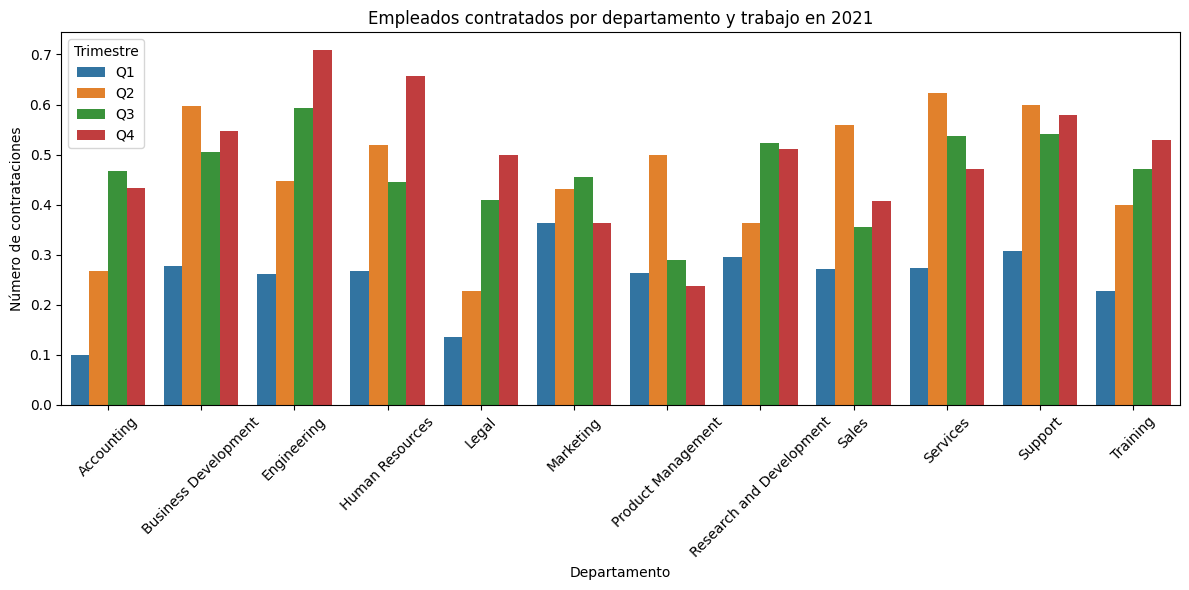

In [208]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Datos de ejemplo (reemplaza esto con los datos reales de tu consulta SQL)
data = df_employees_by_quarter

# Crear un DataFrame
df = pd.DataFrame(data)

# Convertir el DataFrame a formato largo para facilitar la visualización
df_long = df.melt(id_vars=['department', 'job'], var_name='Quarter', value_name='Hires')

# Crear el gráfico de barras agrupadas
plt.figure(figsize=(12, 6))
sns.barplot(x='department', y='Hires', hue='Quarter', data=df_long, ci=None)

# Personalizar el gráfico
plt.title('Empleados contratados por departamento y trabajo en 2021')
plt.xlabel('Departamento')
plt.ylabel('Número de contrataciones')
plt.legend(title='Trimestre')
plt.tight_layout()
# Girar los títulos del eje x
plt.xticks(rotation=45)  # Gira los títulos 45 grados

# Ajustar el layout para que no se corten los títulos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

### List of ids, name and number of employees hired of each department that hired more employees than the mean of employees hired in 2021 for all the departments, ordered by the number of employees hired (descending).

In [132]:
# Consulta para el segundo requisito: Departamentos que contrataron más que la media en 2021
query_departments_above_mean = """
WITH department_hires AS (
    SELECT 
        d.id,
        d.department,
        COUNT(he.id) AS hired
    FROM 
        hired_employees he
    JOIN 
        departments d ON he.department_id = d.id
    WHERE 
        YEAR(he.datetime) = 2021
    GROUP BY 
        d.id, d.department
),
mean_hires AS (
    SELECT 
        AVG(hired) AS mean_hired
    FROM 
        department_hires
)
SELECT 
    dh.id,
    dh.department,
    dh.hired
FROM 
    department_hires dh, mean_hires mh
WHERE 
    dh.hired > mh.mean_hired
ORDER BY 
    dh.hired DESC;
"""
columns_departments_above_mean = ['id', 'department', 'hired']

# Ejecutar la consulta y obtener el DataFrame
df_departments_above_mean = execute_query_to_dataframe(query_departments_above_mean, columns_departments_above_mean)

# Mostrar el DataFrame
if df_departments_above_mean is not None:
    print("\nDepartamentos que contrataron más que la media en 2021:")
    print(df_departments_above_mean)


Departamentos que contrataron más que la media en 2021:
   id                department  hired
0   8                   Support    221
1   5               Engineering    208
2   6           Human Resources    204
3   7                  Services    204
4   4      Business Development    187
5   3  Research and Development    151
6   9                 Marketing    143


C:\Users\JOHN\AppData\Local\Temp\ipykernel_16856\1945882213.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hired', y='department', data=df, palette='viridis')


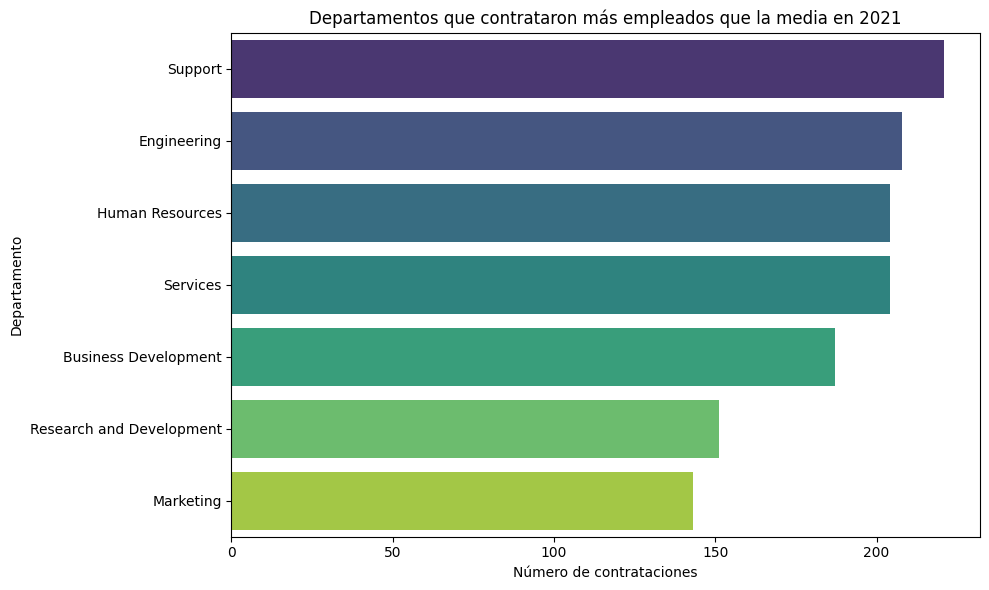

In [214]:
# Datos de ejemplo (reemplaza esto con los datos reales de tu consulta SQL)
data = df_departments_above_mean

# Crear un DataFrame
df = pd.DataFrame(data)

# Crear el gráfico de barras horizontales
plt.figure(figsize=(10, 6))
sns.barplot(x='hired', y='department', data=df, palette='viridis')

# Personalizar el gráfico
plt.title('Departamentos que contrataron más empleados que la media en 2021')
plt.xlabel('Número de contrataciones')
plt.ylabel('Departamento')
plt.tight_layout()

# Mostrar el gráfico
plt.show()